# Encoder CSQA Trace Analysis - Logit Distribution View

This notebook focuses on **distribution differences** between **final-correct** and **final-incorrect** classifications for encoder MCQ traces.

Primary goal:
- characterize which logit-derived signals separate correct vs incorrect cases
- estimate effect size and statistical separation

Trace source expected:
- `src/cli/extract_trace_csqa_enc.py`


In [ ]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from transformers import AutoModelForMultipleChoice
from src.traces_utils.store import TraceStore

plt.style.use("seaborn-v0_8-whitegrid")
np.set_printoptions(precision=4, suppress=True)

In [ ]:
# ---------- CONFIG ----------
RUN_DIR = Path(r"traces\csqa_enc_val250_ft")
MAX_EXAMPLES = None        # int
BOOTSTRAP_SAMPLES = 1000
BOOTSTRAP_SEED = 123
# ----------------------------

assert RUN_DIR.exists(), f"Trace run not found: {RUN_DIR}"
RUN_DIR

WindowsPath('traces/csqa_enc_val250_ft')

In [16]:
st = TraceStore(str(RUN_DIR))
meta = st.meta
arr = st.arrays()

required_cols = ["label_idx", "pred_idx", "is_correct", "choice_logits", "choice_probs"]
missing_cols = [c for c in required_cols if c not in st.tokens.columns]
if missing_cols:
    raise RuntimeError(f"tokens.parquet missing required columns: {missing_cols}")

if "enc_mc_hidden" not in arr:
    raise RuntimeError("enc_mc_hidden is required for layerwise distribution analysis.")

print(json.dumps(meta, indent=2))
print("arrays:", arr)


{
  "run_id": "csqa_enc_val250_ft",
  "model": "checkpoints\\20260212-221720_roberta-base_csqa_mcq_ft",
  "arch": "enc",
  "objective": "mcq_classification",
  "dataset": "csqa",
  "split": "validation",
  "n_examples": 250,
  "n_choices": 5,
  "max_seq_len": 128,
  "num_layers": 12,
  "num_heads": 12,
  "head_dim": 64,
  "dtype": "float16",
  "capture": [
    "hidden",
    "resid"
  ],
  "acc": 0.524,
  "time": "2026-02-14 00:05:06"
}
arrays: {'enc_mc_hidden': (250, 5, 13, 128, 768), 'enc_mc_res_embed': (250, 5, 128, 768), 'enc_mc_res_pre_attn': (250, 5, 12, 128, 768), 'enc_mc_res_post_attn': (250, 5, 12, 128, 768), 'enc_mc_res_post_mlp': (250, 5, 12, 128, 768)}


In [17]:
df = st.tokens.copy().reset_index(drop=True)
if MAX_EXAMPLES is not None:
    df = df.head(int(MAX_EXAMPLES)).reset_index(drop=True)

N = len(df)
if N == 0:
    raise RuntimeError("No examples selected")

choice_labels = list(df.iloc[0]["choice_labels"])
C = len(choice_labels)

y_true = df["label_idx"].astype(int).to_numpy()
y_pred = df["pred_idx"].astype(int).to_numpy()
correct = (y_true == y_pred)

logits = np.vstack([np.asarray(x, dtype=np.float64) for x in df["choice_logits"].tolist()])
probs = np.vstack([np.asarray(x, dtype=np.float64) for x in df["choice_probs"].tolist()])

print("N:", N, "C:", C)
print("final accuracy:", float(correct.mean()))
print("n_correct:", int(correct.sum()), "n_incorrect:", int((~correct).sum()))


N: 250 C: 5
final accuracy: 0.524
n_correct: 131 n_incorrect: 119


In [ ]:
def softmax_np(x, axis=-1):
    z = x - np.max(x, axis=axis, keepdims=True)
    ez = np.exp(z)
    return ez / np.sum(ez, axis=axis, keepdims=True)


def entropy_np(p, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)


def top2_margin(x):
    # x: (N, C)
    part = np.partition(x, -2, axis=1)
    top1 = part[:, -1]
    top2 = part[:, -2]
    return top1 - top2


def cohen_d(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    if len(a) < 2 or len(b) < 2:
        return np.nan
    va = np.var(a, ddof=1)
    vb = np.var(b, ddof=1)
    pooled = np.sqrt(((len(a)-1)*va + (len(b)-1)*vb) / (len(a)+len(b)-2))
    if pooled == 0:
        return np.nan
    return (np.mean(a) - np.mean(b)) / pooled


def cliffs_delta(a, b):
    # O(n*m)
    a = np.asarray(a)
    b = np.asarray(b)
    gt = 0
    lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    denom = len(a) * len(b)
    if denom == 0:
        return np.nan
    return (gt - lt) / denom


def bootstrap_mean_diff(a, b, n_boot=1000, seed=123):
    rng = np.random.default_rng(seed)
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    if len(a) == 0 or len(b) == 0:
        return np.nan, (np.nan, np.nan)
    vals = []
    for _ in range(n_boot):
        aa = a[rng.integers(0, len(a), size=len(a))]
        bb = b[rng.integers(0, len(b), size=len(b))]
        vals.append(np.mean(aa) - np.mean(bb))
    vals = np.asarray(vals)
    return float(np.mean(vals)), (float(np.percentile(vals, 2.5)), float(np.percentile(vals, 97.5)))


def try_ks(a, b):
    try:
        from scipy.stats import ks_2samp
        out = ks_2samp(a, b)
        return float(out.statistic), float(out.pvalue)
    except Exception:
        return np.nan, np.nan


In [ ]:
# Final-layer distribution features Aimed at no access to ground truth needed at inference
p_max = np.max(probs, axis=1)
margin = top2_margin(logits)
ent = entropy_np(probs)
energy = -np.log(np.sum(np.exp(logits - logits.max(axis=1, keepdims=True)), axis=1)) - logits.max(axis=1)
logit_top1 = np.max(logits, axis=1)

features = {
    "p_max": p_max,
    "margin_top1_top2": margin,
    "entropy": ent,
    "energy": energy,
    "logit_top1": logit_top1,
}

rows = []
for name, x in features.items():
    xc = x[correct]
    xi = x[~correct]
    md, ci = bootstrap_mean_diff(xc, xi, BOOTSTRAP_SAMPLES, BOOTSTRAP_SEED)
    ks_stat, ks_p = try_ks(xc, xi)
    rows.append({
        "feature": name,
        "mean_correct": float(np.mean(xc)) if len(xc) else np.nan,
        "mean_incorrect": float(np.mean(xi)) if len(xi) else np.nan,
        "mean_diff(c-i)": md,
        "mean_diff_ci_low": ci[0],
        "mean_diff_ci_high": ci[1],
        "cohen_d": float(cohen_d(xc, xi)),
        "cliffs_delta": float(cliffs_delta(xc, xi)),
        "ks_stat": ks_stat,
        "ks_p": ks_p,
    })

dist_table = pd.DataFrame(rows).sort_values("feature").reset_index(drop=True)
dist_table


,feature,mean_correct,mean_incorrect,mean_diff(c-i),mean_diff_ci_low,mean_diff_ci_high,cohen_d,cliffs_delta,ks_stat,ks_p
0,energy,-1.890156,-1.744623,-0.142127,-0.496138,0.208930,-0.106004,-0.068702,0.097569,0.547422
1,entropy,0.908762,1.129930,-0.222057,-0.301085,-0.143181,-0.676445,-0.367118,0.281352,0.000074
2,logit_top1,1.402470,1.040792,0.358726,-0.011171,0.713032,0.252067,0.150555,0.141125,0.146437
3,margin_top1_top2,1.333306,0.720228,0.621131,0.397578,0.856766,0.656336,0.355186,0.310475,0.000008
4,p_max,0.641194,0.516176,0.125527,0.082180,0.168714,0.728237,0.388543,0.298159,0.000021


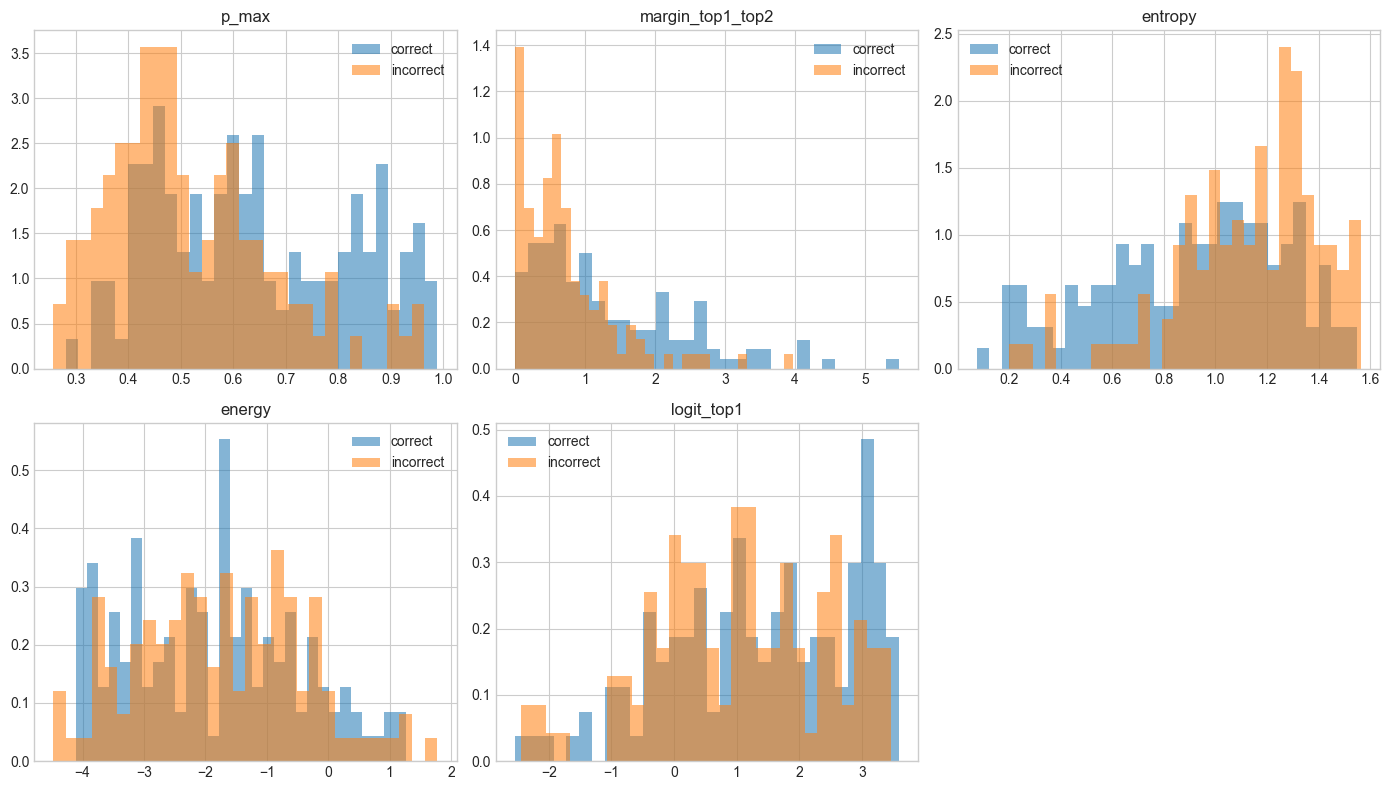

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs = axs.ravel()

for i, (name, x) in enumerate(features.items()):
    ax = axs[i]
    ax.hist(x[correct], bins=30, alpha=0.55, density=True, label="correct")
    ax.hist(x[~correct], bins=30, alpha=0.55, density=True, label="incorrect")
    ax.set_title(name)
    ax.legend()

for j in range(i+1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Layerwise distribution analysis from hidden traces
# Reconstruct per-layer choice logits using the model head.
model_id = meta.get("model", "roberta-base")
mc_model = AutoModelForMultipleChoice.from_pretrained(model_id, attn_implementation="eager")
mc_model.eval()

core = None
for name in ("roberta", "bert", "deberta", "electra"):
    m = getattr(mc_model, name, None)
    if m is not None and hasattr(m, "encoder"):
        core = m
        break
if core is None:
    raise RuntimeError("Unsupported encoder")

classifier = getattr(mc_model, "classifier", None)
if classifier is None:
    raise RuntimeError("MCQ classifier head not found.")

pooler = getattr(core, "pooler", None)
dropout = getattr(mc_model, "dropout", None)
pre_classifier = getattr(mc_model, "pre_classifier", None)


def score_choice_features(cls_feats):
    x = cls_feats
    if pre_classifier is not None:
        x = pre_classifier(x)
        x = torch.tanh(x)
    elif pooler is not None and hasattr(pooler, "dense"):
        x = pooler.dense(x)
        x = torch.tanh(x)
    if dropout is not None:
        x = dropout(x)
    out = classifier(x)
    if out.ndim == 2 and out.shape[1] == 1:
        out = out[:, 0]
    return out

L_plus_1 = int(arr["enc_mc_hidden"][2])
all_layer_logits = np.zeros((N, L_plus_1, C), dtype=np.float32)

with torch.no_grad():
    for i in tqdm(range(N), total=N):
        eid = df.iloc[i]["example_id"]
        choice_h = [st.mcq_hidden(eid, c) for c in range(C)]  # each (L+1,T,D)
        cls_stack = np.stack([h[:, 0, :] for h in choice_h], axis=0)  # (C,L+1,D)

        for li in range(L_plus_1):
            feats = torch.as_tensor(cls_stack[:, li, :], dtype=torch.float32)
            all_layer_logits[i, li] = score_choice_features(feats).cpu().numpy().astype(np.float32)

all_layer_probs = softmax_np(all_layer_logits, axis=2)
print('layer logits shape:', all_layer_logits.shape)

  0%|          | 0/250 [00:00<?, ?it/s]

layer logits shape: (250, 13, 5)


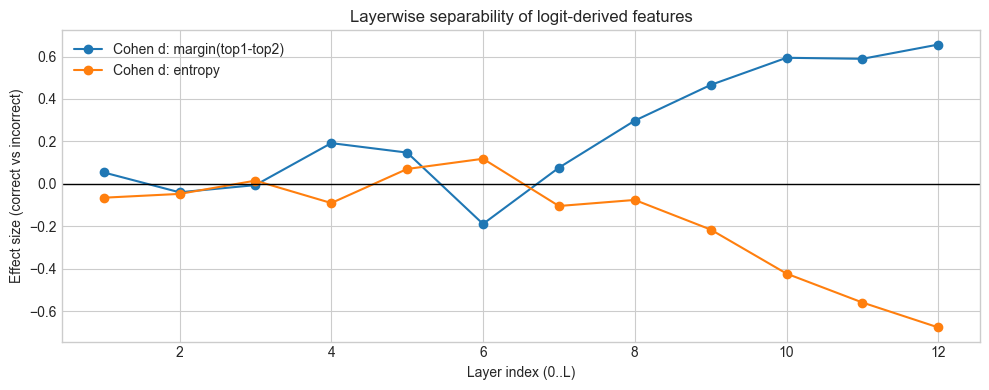

In [ ]:
# Layerwise separability: compare distributions of uncertainty features per layer
layers = np.arange(L_plus_1)
sep_margin = []
sep_entropy = []

for li in range(L_plus_1):
    lg = all_layer_logits[:, li, :]
    pr = all_layer_probs[:, li, :]

    m = top2_margin(lg)
    e = entropy_np(pr)

    d_m = cohen_d(m[correct], m[~correct])
    d_e = cohen_d(e[correct], e[~correct])

    sep_margin.append(d_m)
    sep_entropy.append(d_e)

plt.figure(figsize=(10,4))
plt.plot(layers, sep_margin, marker='o', label='Cohen d: margin(top1-top2)')
plt.plot(layers, sep_entropy, marker='o', label='Cohen d: entropy')
plt.axhline(0.0, color='black', linewidth=1)
plt.xlabel('Layer index (0..L)')
plt.ylabel('Effect size (correct vs incorrect)')
plt.title('Layerwise separability of logit-derived features')
plt.legend()
plt.tight_layout()
plt.show()

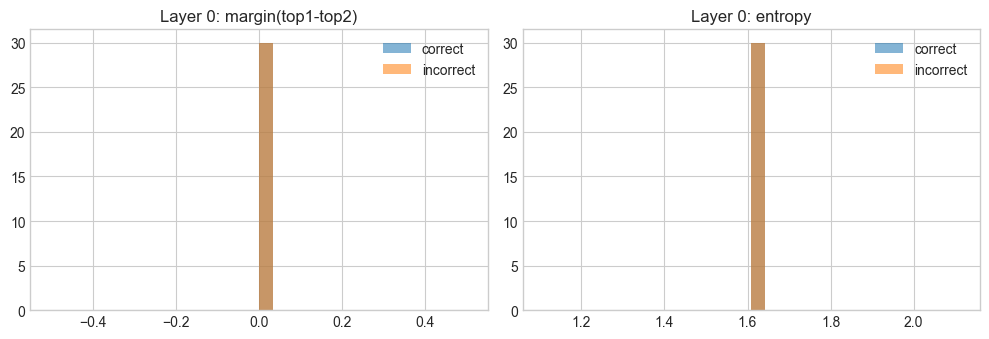

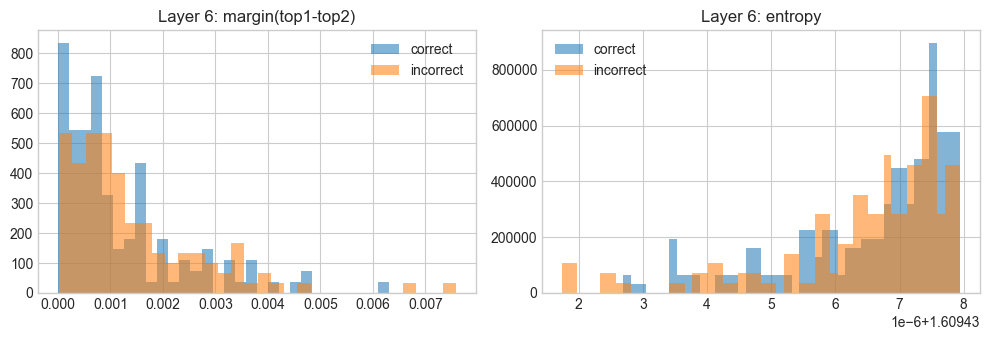

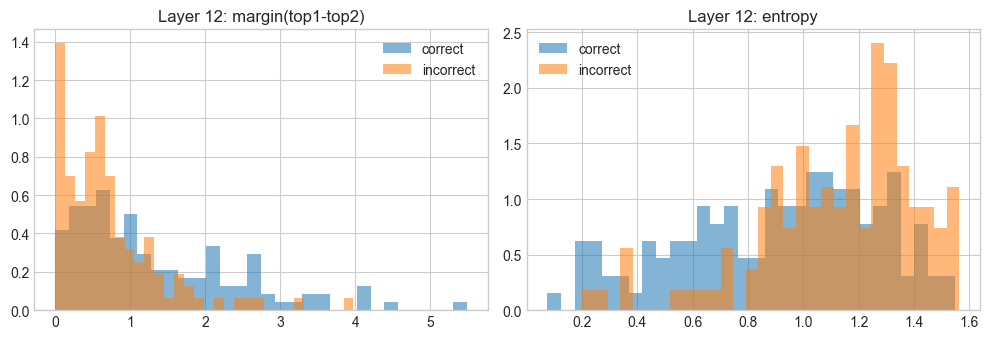

In [23]:
# Layerwise distribution snapshots (selected layers)
selected = sorted(set([0, max(0, L_plus_1//2), L_plus_1-1]))

for li in selected:
    lg = all_layer_logits[:, li, :]
    pr = all_layer_probs[:, li, :]
    m = top2_margin(lg)
    e = entropy_np(pr)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
    axs[0].hist(m[correct], bins=30, alpha=0.55, density=True, label='correct')
    axs[0].hist(m[~correct], bins=30, alpha=0.55, density=True, label='incorrect')
    axs[0].set_title(f'Layer {li}: margin(top1-top2)')
    axs[0].legend()

    axs[1].hist(e[correct], bins=30, alpha=0.55, density=True, label='correct')
    axs[1].hist(e[~correct], bins=30, alpha=0.55, density=True, label='incorrect')
    axs[1].set_title(f'Layer {li}: entropy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
feat_df = pd.DataFrame({
    'example_id': df['example_id'].tolist(),
    'is_correct': correct.astype(int),
    'p_max': p_max,
    'margin_top1_top2': margin,
    'entropy': ent,
    'energy': energy,
    'logit_top1': logit_top1,
})

feat_df.head()


,example_id,is_correct,p_max,margin_top1_top2,entropy,energy,logit_top1
0,701fac8b8c04ab56c4394b2e7b2aa8df,0,0.615608,1.127378,1.089310,-0.805778,0.320633
1,1db37ef1b4ebdcbc12a7d7dec87472a8,1,0.771768,1.596276,0.714229,-3.377550,3.118479
2,a5cb28d53c4cd35c06fbbbb3dbf6aaa8,1,0.684288,1.730273,1.019692,0.366506,-0.745882
3,ce6c00c4f3edcd54ab4fa1e3a8582e7c,1,0.865605,2.596575,0.562515,-1.001444,0.857118
4,054aade2878f1bd189aa590565583d91,0,0.257830,0.038123,1.563612,-1.458388,0.102934
